# Models > XGBoost

<div class="alert alert-info">Estimate and tune an XGBoost model for binary classification</div>

In [1]:
import os

import matplotlib as mpl
import polars as pl
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [2]:
# needs pyrsm version 0.9.16 or higher
# update using pip install --user pyrsm --upgrade
rsm.__version__

'1.7.0'

In [3]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example

As an example we will use a dataset that describes the survival status of individual passengers on the Titanic. The principal source for data about Titanic passengers is the Encyclopedia Titanic. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. Suppose we want to investigate which factors are most strongly associated with the chance of surviving the sinking of the Titanic. Lets focus on four variables in the database:

- survived = a factor with levels `Yes` and `No`
- pclass = Passenger Class (1st, 2nd, 3rd). This is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- sex = Sex (female, male)
- age = Age in years

Select `survived` as the response variable and `Yes` in **Choose level**. Select `pclass`, `sex` and `age` as the explanatory variables. In contrast to Logistic Regression, a Machine Learning model like a XGBoost does not provide coefficients or odds-ratios that we can interpret. Instead, the model provides predictions that we need to evaluate for accuracy. We will also use different plots to better understand what the XGBoost model is telling us about the connection between the explanatory variables (i.e., features) and the response variable (i.e., target).


In [4]:
titanic, titanic_description = rsm.load_data(pkg="data", name="titanic")
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
cat,cat,cat,f64,i32,i32,f64,str,str,cat
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""
…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg"""
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg"""
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg"""


In [5]:
rsm.md(titanic_description)

## Titanic

This dataset describes the survival status of individual passengers on the Titanic. The titanic data frame does not contain information from the crew, but it does contain actual ages of (some of) the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

## Variables

* survival - Survival (Yes, No)
* pclass - Passenger Class (1st, 2nd, 3rd)
* sex - Sex (female, male)
* age - Age in years
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* fare - Passenger Fare
* name - Name
* cabin - Cabin
* embarked - Port of Embarkation (Cherbourg, Queenstown, Southampton)

##  Notes

`pclass` is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

Note: Missing values and the `ticket` variable were removed from the data

## Related reading

<a href="http://phys.org/news/2012-07-shipwrecks-men-survive.html" target="_blank">In shipwrecks, men more likely to survive</a>

In [6]:
titanic.head()

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
cat,cat,cat,f64,i32,i32,f64,str,str,cat
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""


In [7]:
evar = ["pclass", "sex", "age", "sibsp", "parch", "fare"]

In [8]:
clf_xgb = rsm.model.xgboost(
    {"titanic": titanic},
    rvar="survived",
    lev="Yes",
    evar=evar,
    n_estimators=100,
    max_depth=6,
    min_child_weight=1,
    learning_rate=0.3,
    random_state=1234,
)
clf_xgb.summary()

XGBoost
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age, sibsp, parch, fare
Model type           : classification
Nr. of features      : (6, 8)
Nr. of observations  : 1,043
n_estimators         : 100
max_depth            : 6
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.993

Estimation data      :
shape: (5, 8)
┌────────┬───────┬───────┬────────────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sibsp ┆ parch ┆ fare       ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---   ┆ ---   ┆ ---        ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ i32   ┆ i32   ┆ f64        ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪═══════╪═══════╪════════════╪════════════╪══════════╪════════════╪════════════╡
│ 29.0   ┆ 0     ┆ 0     ┆ 211.337494 ┆ 1 

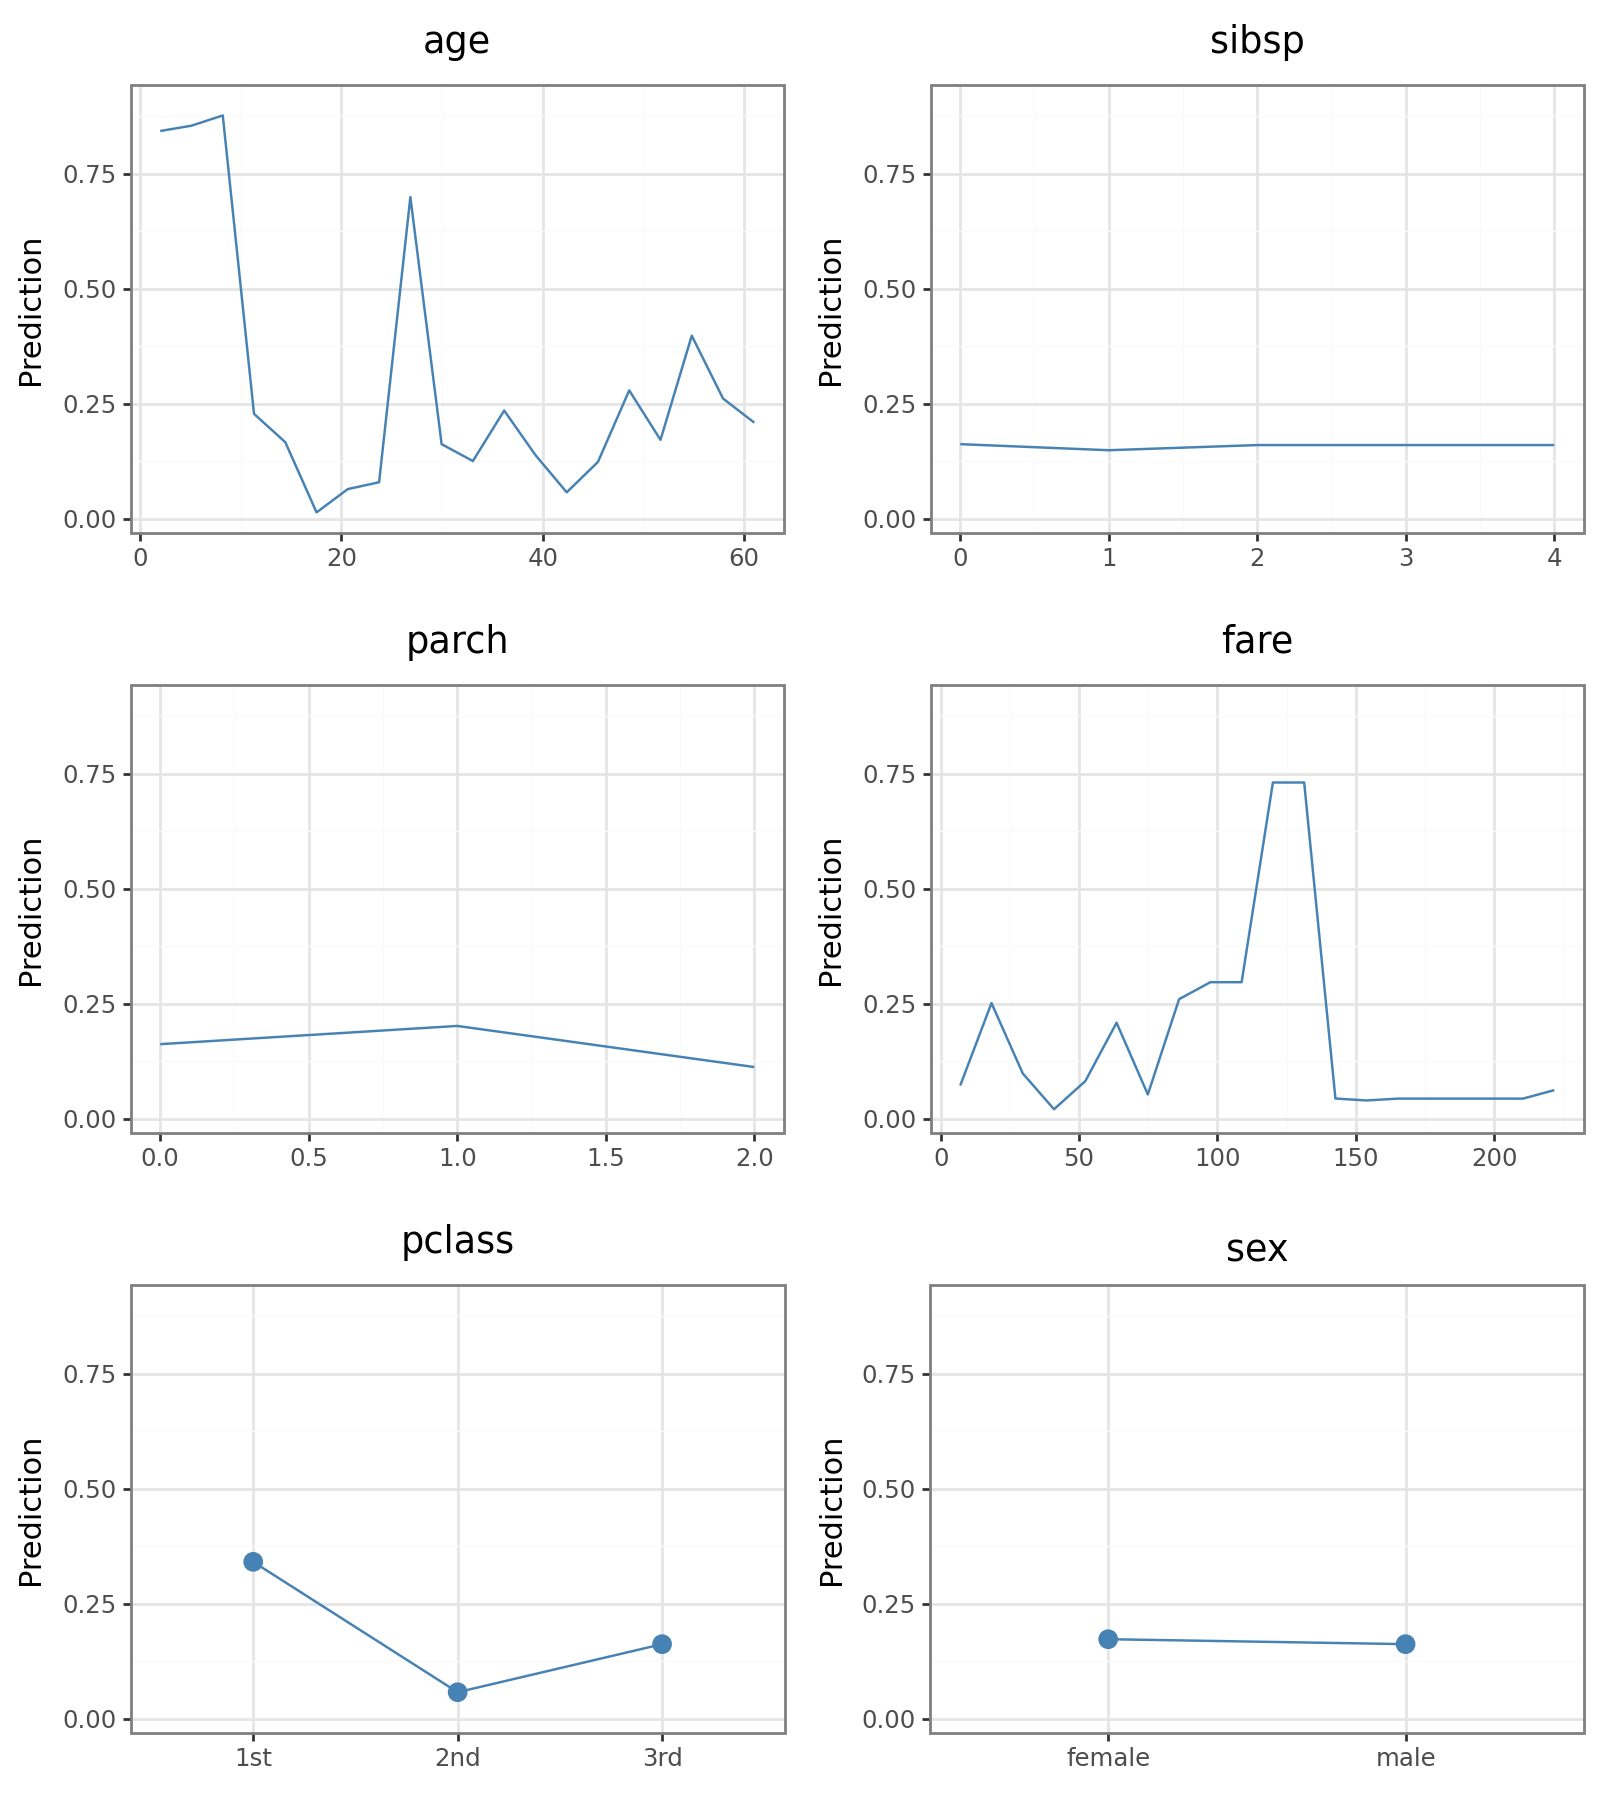

In [9]:
clf_xgb.plot("pred")

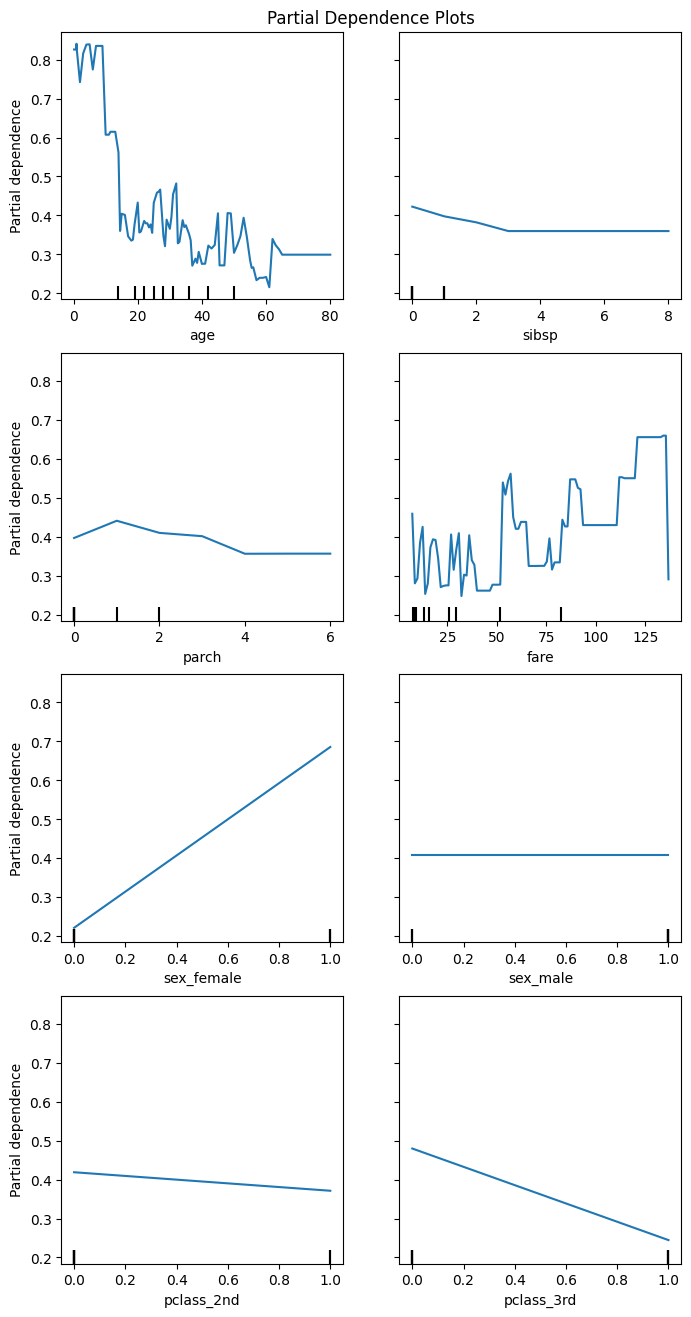

In [10]:
clf_xgb.plot("pdp")

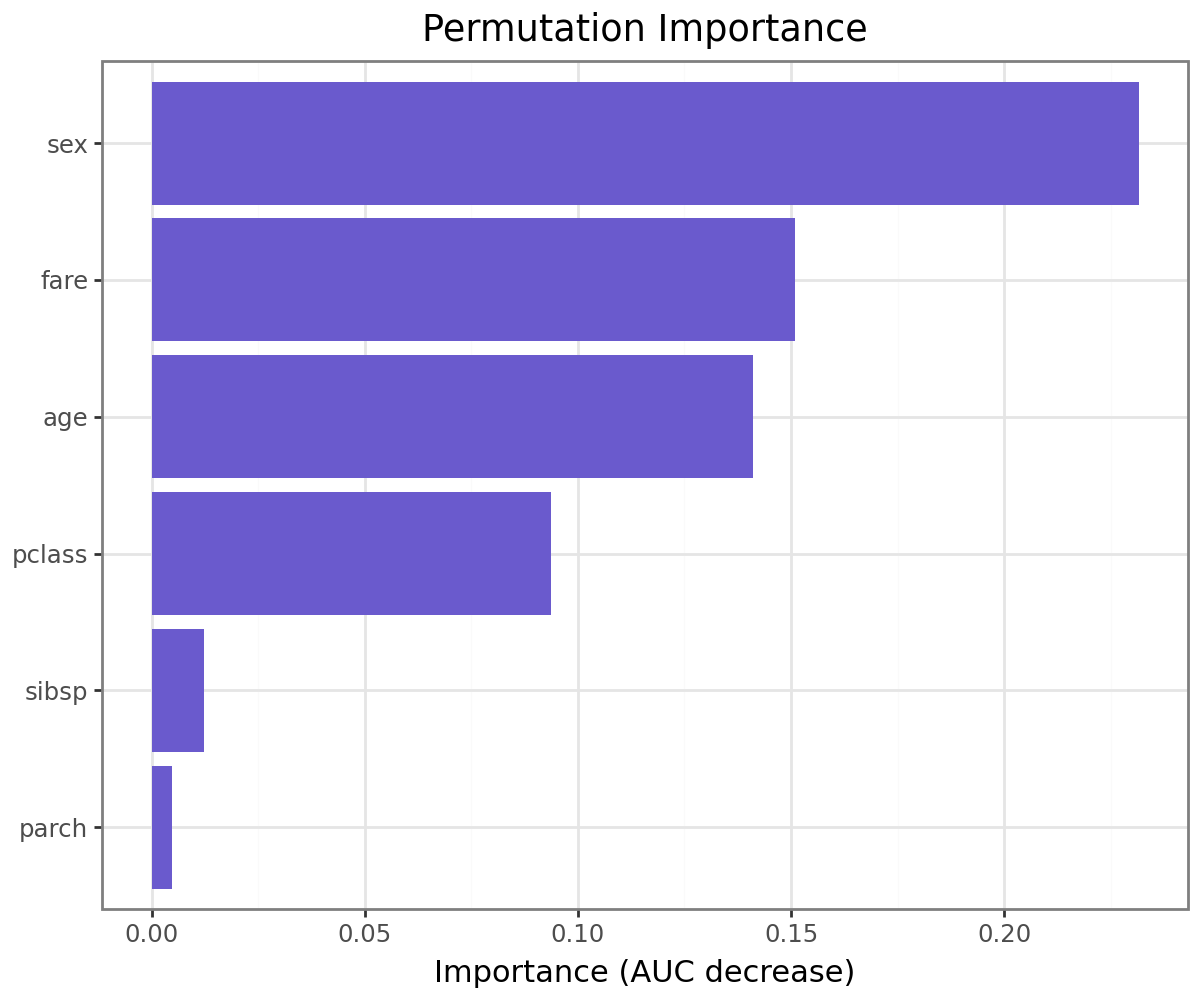

In [11]:
clf_xgb.plot("vimp")

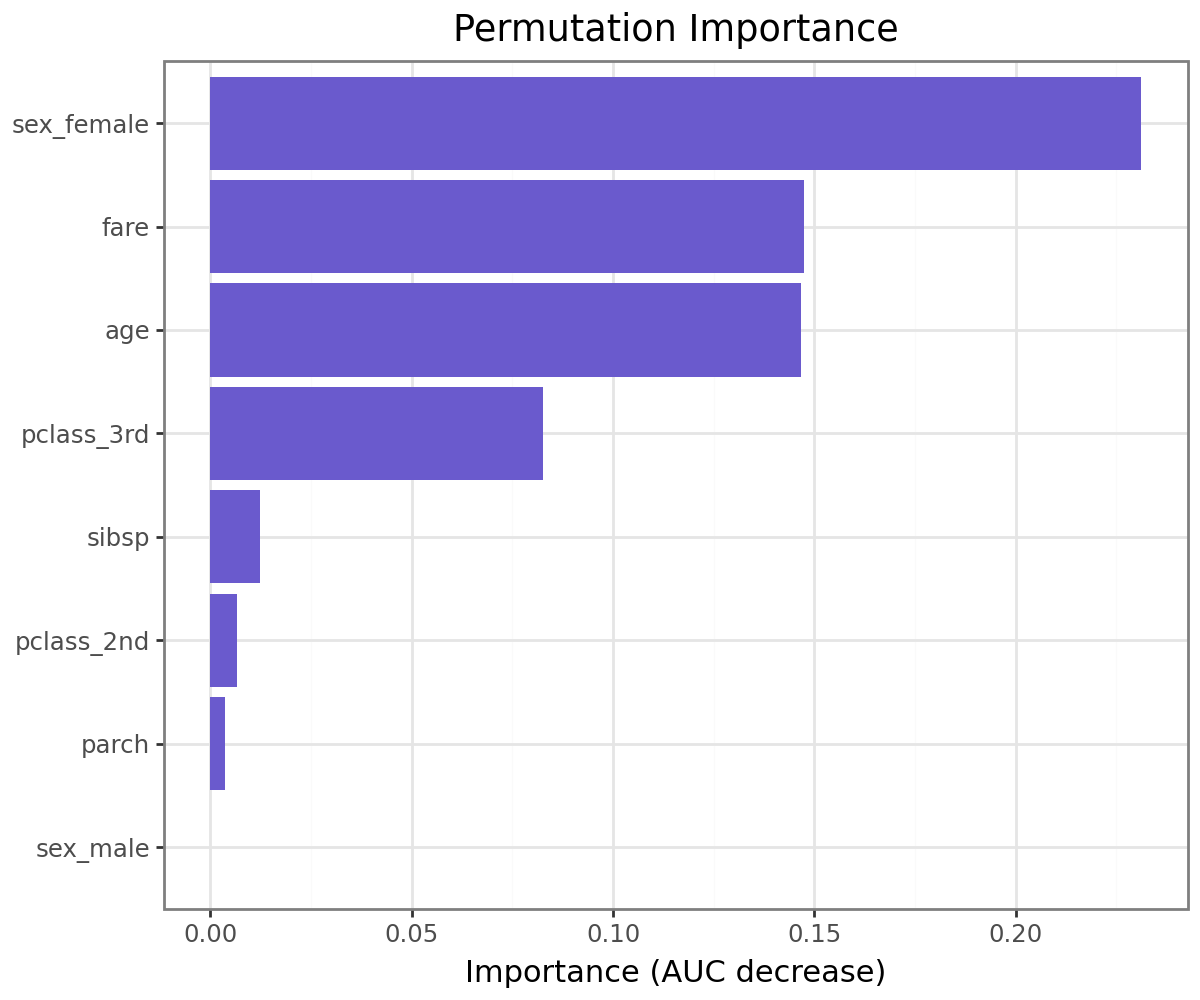

In [12]:
# sklearn calculates permutation importance for each categorical level
# separately which is problematic
clf_xgb.plot("vimp_sklearn")

In [13]:
clf_xgb.predict()

pclass,sex,age,sibsp,parch,fare,prediction
cat,cat,f64,i32,i32,f64,f32
"""1st""","""female""",29.0,0,0,211.337494,0.980506
"""1st""","""male""",0.9167,1,2,151.550003,0.886207
"""1st""","""female""",2.0,1,2,151.550003,0.253101
"""1st""","""male""",30.0,1,2,151.550003,0.012477
"""1st""","""female""",25.0,1,2,151.550003,0.266577
…,…,…,…,…,…,…
"""3rd""","""male""",45.5,0,0,7.2249999,0.007445
"""3rd""","""female""",14.5,1,0,14.4542,0.182372
"""3rd""","""male""",26.5,0,0,7.2249999,0.137711


In addition to the numerical output provided in the _Summary_ tab we can also evaluate the link between `survival`, `class`, `sex`, and `age` visually (see _Plot_ tab). 


# Radiant for Python App: XGBoost - Classification

All the output shown above can be reproduced using the Radiant-for-Python web interface. An example of what the code required to start the web interface is shown below. See if you can reproduce the result.

> Note: The app will continue running until you press the `Stop` button in the app navigation bar or the stop button next to the notebook cell


In [14]:
# uncomment the line below if you want to use the radiant web interface
# rsm.radiant.model.xgboost({"titanic": titanic}, {"titanic": titanic_description})

<p align="center">
<img src="figures/xgb-classification-summary.png">
</p>

<p align="center">
<img src="figures/xgb-classification-pred-plots.png">
</p>


## Tuning an XGBoost classification model

## Tuning an XGBoost model

When building an XGBoost model, there are several hyperparameters that can be tuned to improve model performance. The key parameters we'll focus on are:

- `n_estimators`: Number of boosting rounds/trees (50, 100, 150)
- `max_depth`: Maximum depth of trees (0-6)
- `min_child_weight`: Minimum sum of instance weight needed in a child (1, 5, 10)
- `learning_rate`: Step size to prevent overfitting (0.1, 0.2, 0.3)

To find the optimal combination of these parameters, we:

1. Split our data into training (70%) and test (30%) sets
2. Use grid search with 5-fold cross validation to evaluate different parameter combinations
3. Compare model performance with default vs tuned parameters

First, let's create our train/test split:

In [15]:
titanic = titanic.with_columns(
    training=rsm.model.make_train(titanic, strat_var="survived", test_size=0.3, random_state=1234)
)

In [17]:
clf_xgb = rsm.model.xgboost(
    {"titanic (train)": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    evar=evar,
    n_estimators=100,
    max_depth=6,
    min_child_weight=1,
    learning_rate=0.3,
    random_state=1234,
)
clf_xgb.summary()

XGBoost
Data                 : titanic (train)
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age, sibsp, parch, fare
Model type           : classification
Nr. of features      : (6, 8)
Nr. of observations  : 730
n_estimators         : 100
max_depth            : 6
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.994

Estimation data      :
shape: (5, 8)
┌────────┬───────┬───────┬────────────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sibsp ┆ parch ┆ fare       ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---   ┆ ---   ┆ ---        ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ i32   ┆ i32   ┆ f64        ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪═══════╪═══════╪════════════╪════════════╪══════════╪════════════╪════════════╡
│ 0.9167 ┆ 1     ┆ 2     ┆ 151.55000

In [19]:
titanic = titanic.with_columns(pred_xgb=clf_xgb.predict(titanic).get_column("prediction"))
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked,training,pred_xgb
cat,cat,cat,f64,i32,i32,f64,str,str,cat,i64,f32
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton""",0,0.973377
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton""",1,0.95574
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton""",1,0.170189
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton""",0,0.008614
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton""",1,0.342915
…,…,…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg""",1,0.009378
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg""",0,0.754483
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg""",1,0.164389


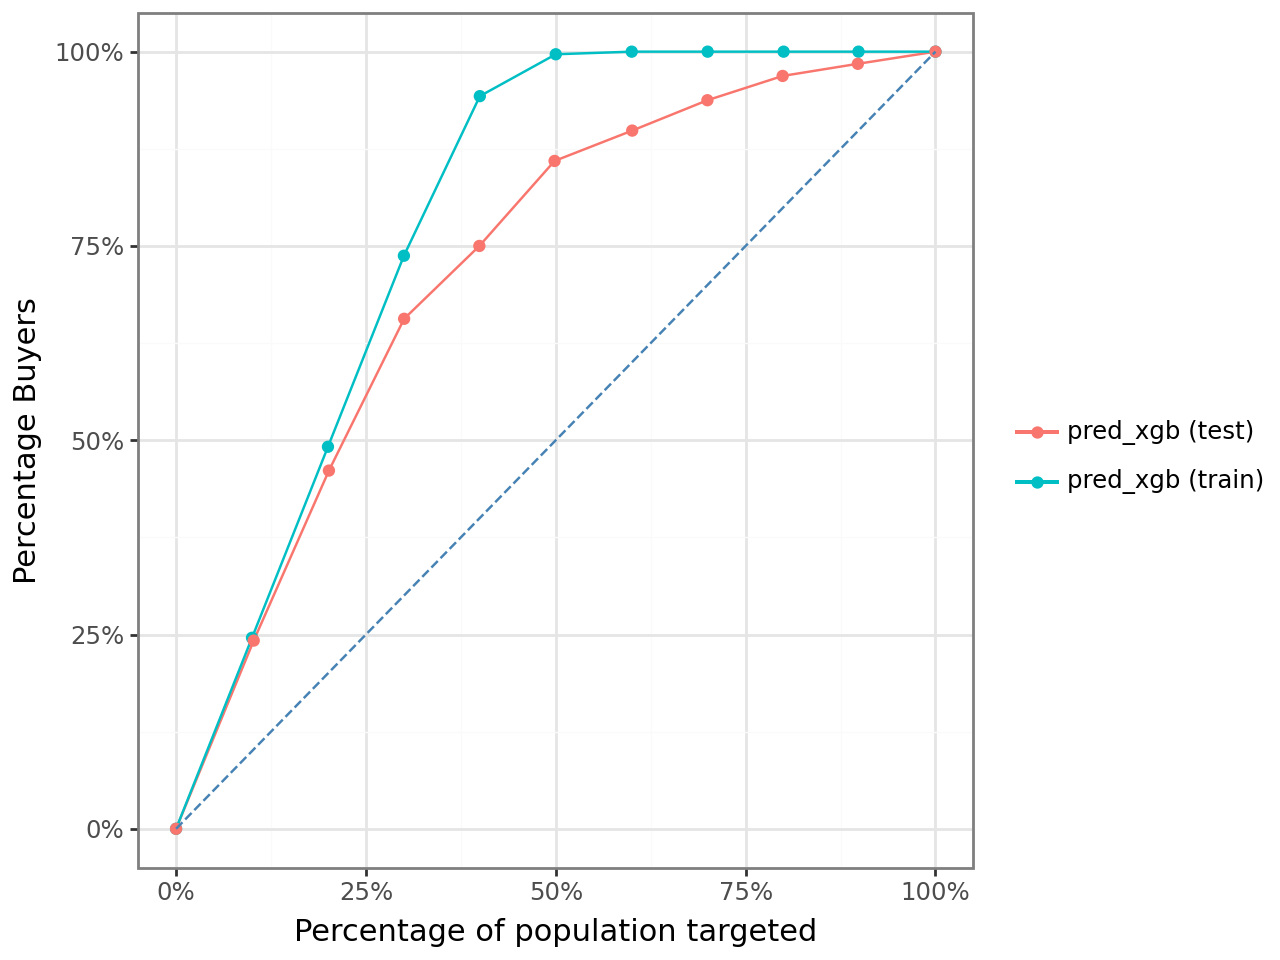

In [21]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_xgb")

The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:
- n_estimators: 50 to 150 trees (in steps of 50)
- max_depth: 0 to 6 levels
- min_child_weight: 1, 5, or 10
- learning_rate: 0.1, 0.2, or 0.3

We'll use the AUC (Area Under the ROC Curve) metric to evaluate performance:

In [22]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": list(range(7)),
    "min_child_weight": [1, 5, 10],
    "learning_rate": [0.1, 0.2, 0.3],
}
scoring = {"AUC": "roc_auc"}
param_grid

{'n_estimators': [50, 100, 150],
 'max_depth': [0, 1, 2, 3, 4, 5, 6],
 'min_child_weight': [1, 5, 10],
 'learning_rate': [0.1, 0.2, 0.3]}

In [23]:
cv_file = "cv-objects/clf-xgb-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.load_state(cv_file)["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        clf_xgb.fitted,
        param_grid,
        scoring=scoring,
        cv=stratified_k_fold,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=5,
    ).fit(clf_xgb.data_onehot.to_pandas(), clf_xgb.data["survived"])
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.save_state({"cv": cv}, cv_file)

Fitting 5 folds for each of 189 candidates, totalling 945 fits
[CV 1/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=50; AUC: (test=0.820) total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=50; AUC: (test=0.791) total time=   0.6s
[CV 5/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=50; AUC: (test=0.786) total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=100; AUC: (test=0.808) total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=100; AUC: (test=0.790) total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=50; AUC: (test=0.844) total time=   0.6s
[CV 4/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=50; AUC: (test=0.866) total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=0, min_child_weight=1, n_estimators=100; AUC: (test=0.835) t

In [ ]:
# same functionality as the cell above but with less typing
cv = rsm.model.cross_validation(clf_xgb, "clf-xgb", param_grid, scoring)

In [ ]:
cv.best_params_

In [ ]:
cv.best_score_

In [ ]:
pl.DataFrame(cv.cv_results_).sort("rank_test_AUC")

In [ ]:
clf_xgbcv = rsm.model.xgboost(
    data={"titanic (train)": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    evar=evar,
    random_state=1234,
    **cv.best_params_,
)
clf_xgbcv.summary()

In [ ]:
titanic = titanic.with_columns(
    pred_xgb=clf_xgb.predict(titanic).get_column("prediction"),
    pred_xgbcv=clf_xgbcv.predict(titanic).get_column("prediction"),
)
titanic

In [ ]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_xgb")

In [ ]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_xgbcv")

In [ ]:
fig = rsm.model.gains_plot(
    {"train": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    pred=["pred_xgb", "pred_xgbcv"],
)

In [ ]:
fig = rsm.model.gains_plot(
    {"test": titanic.filter(pl.col("training") == 0)},
    rvar="survived",
    lev="Yes",
    pred=["pred_xgb", "pred_xgbcv"],
)